In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os
import pickle
import joblib
import threading
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV

from sklearn.metrics import classification_report as clf_report
from sklearn.metrics import (
    accuracy_score,
    recall_score,
    precision_score,
    f1_score
)

# Сначала field

Возьмем df с удаленными не-английскими текстами:

In [2]:
df = pd.read_pickle("looong_df_subjects_en.pkl")
df.head()

,DOI,title,abstract,subject,cleaned_abstract,filtered_subject,all_fields,field_Art,field_Biology,field_Business,...,subj_Biological Psychiatry,subj_Gender Studies,"subj_Safety, Risk, Reliability and Quality",subj_Urban Studies,subj_Genetics(clinical),subj_Agricultural and Biological Sciences (miscellaneous),subj_Museology,subj_Nephrology,subj_Logic,lang
0,10.1163/1568525043083505,aristotle fr. 44 rose: midas and silenus,<jats:sec><jats:title>Abstract</jats:title><ja...,"[Classics, Linguistics and Language, Archaeolo...",abstract scholars have identified two supposed...,"[Archaeology, Classics, History, Language and ...","[Humanities, Humanities, Humanities, Humanitie...",0,0,0,...,0,0,0,0,0,0,0,0,0,en
1,10.1163/1568525043083532,loca loquuntur. lucretius' explanation of the ...,<jats:sec><jats:title>Abstract</jats:title><ja...,"[Classics, Linguistics and Language, Archaeolo...",abstract a discussion of the second part of lu...,"[Archaeology, Classics, History, Language and ...","[Humanities, Humanities, Humanities, Humanitie...",0,0,0,...,0,0,0,0,0,0,0,0,0,en
2,10.1163/1568525043083541,poverty and demography: the case of the gracch...,<jats:sec><jats:title>Abstract</jats:title><ja...,"[Classics, Linguistics and Language, Archaeolo...",abstract according to many ancient historians ...,"[Archaeology, Classics, History, Language and ...","[Humanities, Humanities, Humanities, Humanitie...",0,0,0,...,0,0,0,0,0,0,0,0,0,en
3,10.1163/1568525043083514,old persian in athens revisited (ar. ach. 100),<jats:sec><jats:title>Abstract</jats:title><ja...,"[Classics, Linguistics and Language, Archaeolo...",abstract the old persian line in aristophanes ...,"[Archaeology, Classics, History, Language and ...","[Humanities, Humanities, Humanities, Humanitie...",0,0,0,...,0,0,0,0,0,0,0,0,0,en
4,10.1163/1568527053083412,religion and violence: what can sociology offer?,<jats:sec><jats:title>Abstract</jats:title><ja...,"[Religious studies, History]",abstract this essay presents a sketch of a soc...,"[History, Religious studies]","[Humanities, Humanities]",0,0,0,...,0,0,0,0,0,0,0,0,0,en


In [3]:
target_1 = [column for column in df.columns if "field_" in column]
X_train, X_test, y_train, y_test = train_test_split(df["cleaned_abstract"], df[target_1],
                                                    train_size=0.8, test_size=0.2,
                                                    random_state=42)

In [4]:
y_train_fields = {
    field: y_train[field] for field in target_1
}

In [5]:
%%time
if os.path.exists("vectorizer_full.pkl"):
    vectorizer = joblib.load("vectorizer_full.pkl")
else:
    vectorizer = TfidfVectorizer(ngram_range=(1, 2)).fit(X_train)
    with open("vectorizer_full.pkl", "wb") as f:
        pickle.dump(vectorizer, f)
X_train_transformed = vectorizer.transform(X_train)

CPU times: user 9min 33s, sys: 27.7 s, total: 10min 1s
Wall time: 11min 21s


In [6]:
%%time

if os.path.isdir("field_svc_en_full_data"):
    svcs = {
        field: pickle.load(open(f"field_svc_en_full_data/{field}.pkl", "rb"))
        for field in target_1
}

    
else:
    svcs = {
        field: CalibratedClassifierCV(
            LinearSVC(random_state=123)
        ) for field in target_1
    }

    def fit_svc(field, svc):
        print(f'Fitting {field} SVM')
        svc.fit(X_train_transformed, y_train_fields[field])
        print(f'Done fitting {field} SVM')
        filename = f'field_svc_en_full_data/{field}.pkl'
        with open(filename, 'wb') as f:
            pickle.dump(svc, f)
        print(f'Saved {filename}')

    tasks = []

    for field, svc in svcs.items():
        task = threading.Thread(
            target=fit_svc,
            args=(field, svc),
            daemon=True,
        )
        task.start()
        tasks.append(task)

    for task in tasks:
        task.join()

CPU times: user 0 ns, sys: 11.6 s, total: 11.6 s
Wall time: 43.6 s


In [7]:
%%time
X_test_transformed = vectorizer.transform(X_test)

CPU times: user 2min 1s, sys: 7.89 s, total: 2min 9s
Wall time: 3min 23s


In [8]:
accuracy = {}
recall = {}
precision = {}
f1 = {}

accs = []
recs = []
precs = []
f1s = []

min_positives = np.arange(start=0.05, stop=0.5, step=0.05)
for min_positive in tqdm(min_positives):
    for subj in target_1:
        #print(subj.upper())
        y_pred = svcs[subj].predict_proba(X_test_transformed)
        y_pred = [1 if x[1] > min_positive else 0 for x in y_pred]
        accuracy[subj] = accuracy_score(y_test[subj], y_pred)
        recall[subj] = recall_score(y_test[subj], y_pred, zero_division=0)
        precision[subj] = precision_score(y_test[subj], y_pred, zero_division=0)
        f1[subj] = f1_score(y_test[subj], y_pred, zero_division=0)
    
    accs.append(np.mean(list(accuracy.values())))
    recs.append(np.mean(list(recall.values())))
    precs.append(np.mean(list(precision.values())))
    f1s.append(np.mean(list(f1.values())))

In [9]:
for field in target_1:
    y_pred = svcs[field].predict_proba(X_test_transformed)
    y_pred = [1 if x[1] > 0.3 else 0 for x in y_pred]
    print(field.upper())
    print(clf_report(y_test[field], y_pred))
    print()

FIELD_ART
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    392905
           1       0.67      0.66      0.66      3988

    accuracy                           0.99    396893
   macro avg       0.83      0.83      0.83    396893
weighted avg       0.99      0.99      0.99    396893


FIELD_BIOLOGY
              precision    recall  f1-score   support

           0       0.95      0.91      0.93    270241
           1       0.82      0.89      0.85    126652

    accuracy                           0.90    396893
   macro avg       0.88      0.90      0.89    396893
weighted avg       0.90      0.90      0.90    396893


FIELD_BUSINESS
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    385264
           1       0.67      0.66      0.67     11629

    accuracy                           0.98    396893
   macro avg       0.83      0.82      0.83    396893
weighted avg       0.98      0.98

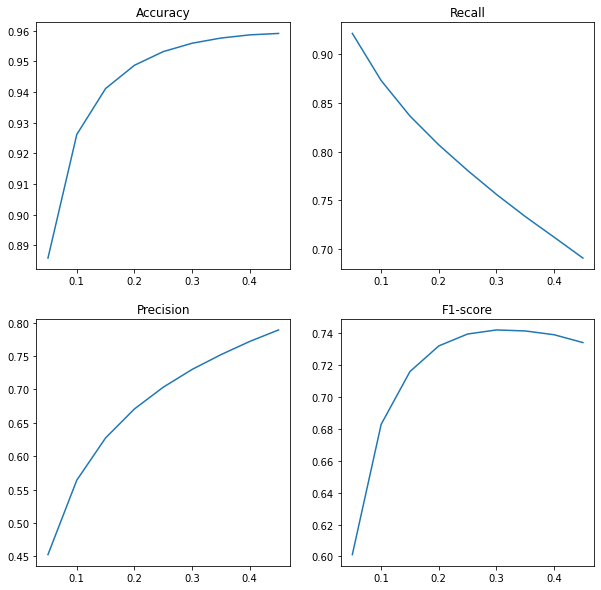

In [10]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

axs[0, 0].plot(min_positives, accs)
axs[0, 0].set_title("Accuracy")

axs[0, 1].plot(min_positives, recs)
axs[0, 1].set_title("Recall")

axs[1, 0].plot(min_positives, precs)
axs[1, 0].set_title("Precision")

axs[1, 1].plot(min_positives, f1s)
axs[1, 1].set_title("F1-score")

plt.show()

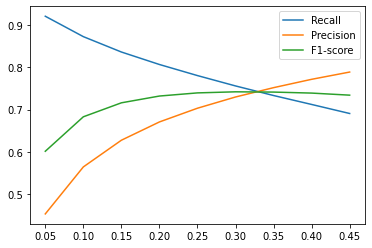

In [11]:
plt.plot(min_positives, recs, label="Recall")
plt.plot(min_positives, precs, label="Precision")
plt.plot(min_positives, f1s, label="F1-score")
plt.legend()
plt.show()

In [12]:
accuracy = {}
recall = {}
precision = {}
f1 = {}

for subj in target_1:
        #print(subj.upper())
        y_pred = svcs[subj].predict_proba(X_test_transformed)
        y_pred = [1 if x[1] > 0.3 else 0 for x in y_pred]
        accuracy[subj] = accuracy_score(y_test[subj], y_pred)
        recall[subj] = recall_score(y_test[subj], y_pred, zero_division=0)
        precision[subj] = precision_score(y_test[subj], y_pred, zero_division=0)
        f1[subj] = f1_score(y_test[subj], y_pred, zero_division=0)

In [13]:
print(f"Average accuracy: {np.mean(list(accuracy.values()))}")
print(f"Average recall: {np.mean(list(recall.values()))}")
print(f"Average precision: {np.mean(list(precision.values()))}")
print(f"Average F1-score: {np.mean(list(f1.values()))}")

Average accuracy: 0.9558986930986438
Average recall: 0.7560219755958483
Average precision: 0.7298036490285801
Average F1-score: 0.7420732967055291


# Subject с фичей field

In [8]:
X_test_copy = pd.DataFrame(X_test.copy())

for field in target_1:
    y_pred = svcs[field].predict_proba(X_test_transformed)
    y_pred = [1 if x[1] > 0.25 else 0 for x in y_pred]
    X_test_copy[f"{field}_pred"] = y_pred

In [9]:
# free up memory
import gc

del(svcs)
gc.collect()

51

In [10]:
X_test_copy.sample(5)

,cleaned_abstract,field_Art_pred,field_Biology_pred,field_Business_pred,field_Chemistry_pred,field_Geology_pred,field_Humanities_pred,field_Math_pred,field_Medicine_pred,field_Physics_pred,field_Psychology_pred,field_Social_pred,field_Tech_pred
358592,abstract in species exhibiting infanticide by ...,0,1,0,0,0,0,0,0,0,0,0,0
1726209,background the idiopathic esophageal achalasia...,0,0,0,0,0,0,0,1,0,0,0,0
1768128,a new lifepo4 based phase composite life0 95ti...,0,0,0,0,0,0,0,0,1,0,0,0
1533517,on april 14 1918 charles i the last ruler of t...,0,0,0,0,0,1,0,0,0,0,0,0
63465,the ability of populus tremuloides michx to fo...,0,1,0,0,0,0,0,0,0,0,0,0


И начинаем предсказывать сабжекты:

In [11]:
target_2 = [column for column in df.columns if "subj_" in column]
X_train, X_test, y_train, y_test = train_test_split(df[["cleaned_abstract"] + target_1], df[target_2],
                                                    train_size=0.8, test_size=0.2,
                                                    random_state=42)

In [12]:
y_train_subjs = {
    subj: y_train[subj] for subj in target_2
}

In [ ]:
#%%time
#vectorizer = TfidfVectorizer(ngram_range=(1, 2))
#X_train_transformed = vectorizer.fit_transform(X_train["cleaned_abstract"])

In [13]:
from scipy import sparse

X_train_stacked = sparse.hstack((
    X_train_transformed,
    sparse.csr_matrix(X_train[target_1])
))

In [14]:
%%time
fit = 0
semaphore = threading.Semaphore(2)

def fit_svc(field, svc):
    global fit
    semaphore.acquire()
    try:
        svc.fit(X_train_stacked, y_train_subjs[field])
        fit += 1
        if fit % 10 == 0:
            print(f'Done fitting {fit}/200 SVM')
        filename = f'subj_svc_en_full_data/{field}.pkl'
        with open(filename, 'wb') as f:
            pickle.dump(svc, f)
        # to free up RAM
        del svc
        del subj_svcs[field]
        gc.collect()
    finally:
        semaphore.release()


tasks = []

subj_svcs = {
    subj: CalibratedClassifierCV(
        LinearSVC(random_state=123)
    ) for subj in target_2
}

for subj, svc in subj_svcs.items():
    #if os.path.exists(f"subj_svc_en_full_data/{subj}.pkl"):
    #    subj_svcs[subj] = pickle.load(open(f"subj_svc_en_full_data/{subj}.pkl", "rb"))
    #    fit += 1
    #    if fit % 20 == 0:
    #        print(f'Done fitting {fit}/200 SVM')
    if not os.path.exists(f"subj_svc_en_full_data/{subj}.pkl"):
        task = threading.Thread(
            target=fit_svc,
            args=(subj, svc),
            daemon=True,
        )
        task.start()
        tasks.append(task)

for task in tqdm(tasks):
    task.join()

Done fitting 5/16 SVM
Done fitting 10/16 SVM
Done fitting 15/16 SVM

CPU times: user 31min 3s, sys: 15min 21s, total: 46min 24s
Wall time: 47min 19s


In [14]:
#X_test_transformed = vectorizer.transform(X_test["cleaned_abstract"])

X_test_stacked = sparse.hstack((
    X_test_transformed,
    sparse.csr_matrix(X_test_copy[[f"{field}_pred" for field in target_1]])
))

In [ ]:
if os.path.isdir("subj_svc_en_full_data"):
    svcs = {
        subj: pickle.load(open(f"subj_svc_en_full_data/{subj}.pkl", "rb"))
        for subj in tqdm(target_2)
}

In [ ]:
from tqdm.notebook import tqdm


accuracy = {}
recall = {}
precision = {}
f1 = {}

accs = []
recs = []
precs = []
f1s = []

min_positives = np.arange(start=0.05, stop=0.5, step=0.05)
min_positives = [0.1, 0.3, 0.5]
for min_positive in tqdm(min_positives):
    for subj in tqdm(target_2):
        y_pred = subj_svcs[subj].predict_proba(X_test_stacked)

        y_pred = [1 if x[1] > min_positive else 0 for x in y_pred]
        accuracy[subj] = accuracy_score(y_test[subj], y_pred)
        recall[subj] = recall_score(y_test[subj], y_pred, zero_division=0)
        precision[subj] = precision_score(y_test[subj], y_pred, zero_division=0)
        f1[subj] = f1_score(y_test[subj], y_pred, zero_division=0)
    
    accs.append(np.mean(list(accuracy.values())))
    recs.append(np.mean(list(recall.values())))
    precs.append(np.mean(list(precision.values())))
    f1s.append(np.mean(list(f1.values())))

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

axs[0, 0].plot(min_positives, accs)
axs[0, 0].set_title("Accuracy")

axs[0, 1].plot(min_positives, recs)
axs[0, 1].set_title("Recall")

axs[1, 0].plot(min_positives, precs)
axs[1, 0].set_title("Precision")

axs[1, 1].plot(min_positives, f1s)
axs[1, 1].set_title("F1-score")

plt.show()

In [ ]:
plt.plot(min_positives, recs, label="Recall")
plt.plot(min_positives, precs, label="Precision")
plt.plot(min_positives, f1s, label="F1-score")
plt.legend()
plt.show()

In [ ]:
for subj in tqdm(target_2):
    y_pred = subj_svcs[subj].predict_proba(X_test_stacked)

    y_pred = [1 if x[1] > 0.3 else 0 for x in y_pred]
    accuracy[subj] = accuracy_score(y_test[subj], y_pred)
    recall[subj] = recall_score(y_test[subj], y_pred, zero_division=0)
    precision[subj] = precision_score(y_test[subj], y_pred, zero_division=0)
    f1[subj] = f1_score(y_test[subj], y_pred, zero_division=0)
    
    accs.append(np.mean(list(accuracy.values())))
    recs.append(np.mean(list(recall.values())))
    precs.append(np.mean(list(precision.values())))
    f1s.append(np.mean(list(f1.values())))

In [ ]:
print(f"Average accuracy: {np.mean(list(accuracy.values()))}")
print(f"Average recall: {np.mean(list(recall.values()))}")
print(f"Average precision: {np.mean(list(precision.values()))}")
print(f"Average F1-score: {np.mean(list(f1.values()))}")